**Coding Resources**
- https://github.com/lestercardoz11/SP-500-index-anomaly-detection - (S&P 500 anomaly detection repository)
- https://curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/ - (S&P 500 anomaly detection tutorial)
- https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/ - (pytorch LSTM implementation tutorial)
- https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/ - (pytorch LSTM implementation tutorial, more relevant)

In [103]:
import torch.nn as nn
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch import optim
from torch.utils import data

**S&P 500 Daily Prices 1986-2018**

In [104]:
filepath = './data/spx.csv'
df = pd.read_csv(filepath)
print(df.shape)
df.head()

(8192, 2)


,date,close
0,02-Jan-86,209.59
1,03-Jan-86,210.88
2,06-Jan-86,210.65
3,07-Jan-86,213.80
4,08-Jan-86,207.97


**Visualize Data**

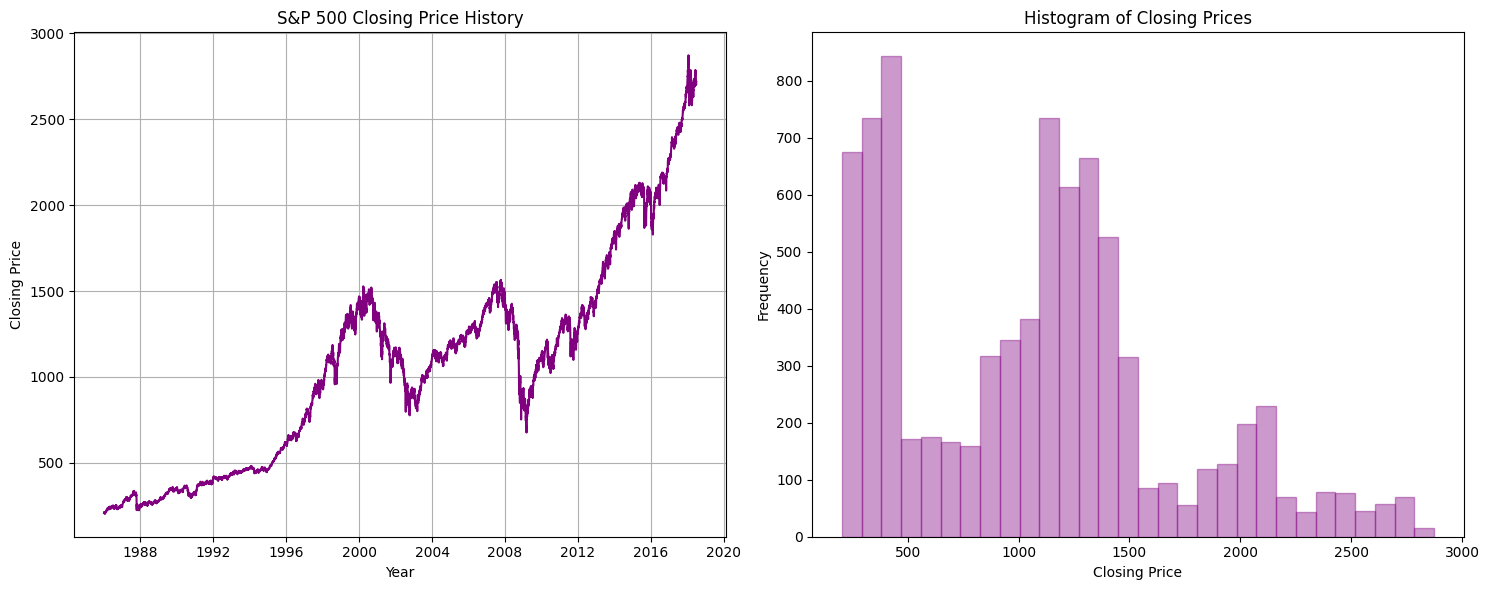

In [105]:
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%y')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# plot time series data
ax1.plot(df['date'], df['close'], color='purple')
ax1.set_xlabel('Year')
ax1.set_ylabel('Closing Price')
ax1.set_title('S&P 500 Closing Price History')
ax1.grid(True)

# plot histogram
ax2.hist(df['close'], bins=30, color='purple', edgecolor='purple', alpha=0.4, histtype='bar')
ax2.set_title('Histogram of Closing Prices')
ax2.set_xlabel('Closing Price')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**Split & Standardize Data**

In [106]:
# split dataset (85% training, 10% validation, 5% testing)
train_df, test_df = train_test_split(df, test_size=0.05, shuffle=False)
train_df, valid_df = train_test_split(train_df, test_size=0.1, shuffle=False)

print("Train Dataframe:", train_df.shape)
print("Val Dataframe:", valid_df.shape)
print("Test Dataframe: ", test_df.shape)

Train Dataframe: (7003, 2)
Val Dataframe: (779, 2)
Test Dataframe:  (410, 2)


In [107]:
# scalar fit to training data
scaler = StandardScaler()
scaler.fit(train_df[['close']])

# standardize datasets based on training data
train_df.loc[:, 'close'] = scaler.transform(train_df[['close']])
valid_df.loc[:, 'close'] = scaler.transform(valid_df[['close']])
test_df.loc[:, 'close'] = scaler.transform(test_df[['close']])

print("Train Mean:", train_df['close'].mean(), "Train Standard Deviation:", train_df['close'].std())
print("Val Mean:", valid_df['close'].mean(), "Val Standard Deviation:", valid_df['close'].std())
print("Test Mean:", test_df['close'].mean(), "Test Standard Deviation:", test_df['close'].std())

Train Mean: 0.0 Train Standard Deviation: 1.0000714056197133
Val Mean: 2.581022834703127 Val Standard Deviation: 0.26642494271518524
Test Mean: 3.757597524858125 Test Standard Deviation: 0.40463254744634136


**Prepare Datasets**

In [108]:
def create_dataset(df, lookback=1):
    X, y = [], []

    for i in range(len(df) - lookback):
        feature = df.iloc[i:i+lookback].values.astype(np.float32)
        target = df.iloc[i+1:i+lookback+1].values.astype(np.float32)
        X.append(feature)
        y.append(target)

    return torch.tensor(X), torch.tensor(y)

In [109]:
lookback = 30 # capacity of sliding window

X_train, y_train = create_dataset(train_df[['close']], lookback)
X_valid, y_valid = create_dataset(valid_df[['close']], lookback)
#X_test, y_test = create_dataset(test_df[['close']], TIME_STEPS)

print("Training Samples:", len(X_train))
print("Validation Samples:", len(X_valid))
#print("Testing Samples:", len(X_test))

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

Training Samples: 6973
Validation Samples: 749
torch.Size([6973, 30, 1]) torch.Size([6973, 30, 1])
torch.Size([749, 30, 1]) torch.Size([749, 30, 1])


In [110]:
batch_size = 8
train_loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
valid_loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)

**LSTM Autoencoder**

In [111]:
class AutoencoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(AutoencoderLSTM, self).__init__()
        self.encoder = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder = nn.LSTM(input_size=hidden_size, hidden_size=input_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        encoded, _ = self.encoder(x)
        encoded = self.dropout(encoded)
        decoded, _ = self.decoder(encoded)
        return decoded

**Training Loop**

In [112]:
def train_epoch(device, model, optimizer, criterion, train_loader):
    model.train()
    train_loss = 0.0

    prog_bar = tqdm(train_loader, desc=f'Training', leave=False)

    for inputs, targets in prog_bar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        prog_bar.set_postfix({'Train Loss': train_loss / len(prog_bar)})

    return train_loss / len(train_loader)

In [113]:
def validate_epoch(device, model, criterion, valid_loader):
    model.eval()
    val_loss = 0.0

    prog_bar = tqdm(valid_loader, desc='Validation', leave=False)

    with torch.no_grad():                   # is this necessary?
        for inputs, targets in prog_bar:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            prog_bar.set_postfix({'Val Loss': val_loss / len(prog_bar)})

    return val_loss / len(valid_loader)

In [114]:
def train_model(device, model, optimizer, criterion, train_loader, valid_loader, num_epochs):
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        train_loss = train_epoch(device, model, optimizer, criterion, train_loader)
        val_loss = validate_epoch(device, model, criterion, valid_loader)

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_loss_history, val_loss_history

**Training Evaluation**

In [116]:
# instantiate device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# instantiate model and parameters
model = AutoencoderLSTM(input_size=1, hidden_size=4, num_layers=1)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.05)
criterion = nn.MSELoss()

train_loss_history, valid_loss_history = train_model(device, model, optimizer, criterion, train_loader, valid_loader, num_epochs=20)

Epoch 1/20, Train Loss: 0.1823, Val Loss: 0.0660


Epoch 2/20, Train Loss: 0.0626, Val Loss: 0.0557


Epoch 3/20, Train Loss: 0.0593, Val Loss: 0.0585


Epoch 4/20, Train Loss: 0.0597, Val Loss: 0.0574


Epoch 5/20, Train Loss: 0.0585, Val Loss: 0.0542


Epoch 6/20, Train Loss: 0.0567, Val Loss: 0.0554


Epoch 7/20, Train Loss: 0.0566, Val Loss: 0.0554


Epoch 8/20, Train Loss: 0.0570, Val Loss: 0.0546


Epoch 9/20, Train Loss: 0.0565, Val Loss: 0.0558


Epoch 10/20, Train Loss: 0.0576, Val Loss: 0.0586


Epoch 11/20, Train Loss: 0.0566, Val Loss: 0.0602


Epoch 12/20, Train Loss: 0.0558, Val Loss: 0.0619


Epoch 13/20, Train Loss: 0.0555, Val Loss: 0.0612


Epoch 14/20, Train Loss: 0.0556, Val Loss: 0.0636


Epoch 15/20, Train Loss: 0.0554, Val Loss: 0.0617


Epoch 16/20, Train Loss: 0.0553, Val Loss: 0.0657


Epoch 17/20, Train Loss: 0.0555, Val Loss: 0.0640


Epoch 18/20, Train Loss: 0.0552, Val Loss: 0.0596


Epoch 19/20, Train Loss: 0.0553, Val Loss: 0.0661


Epoch 20/20, Train Loss: 0.0552, Val Loss: 0.0731


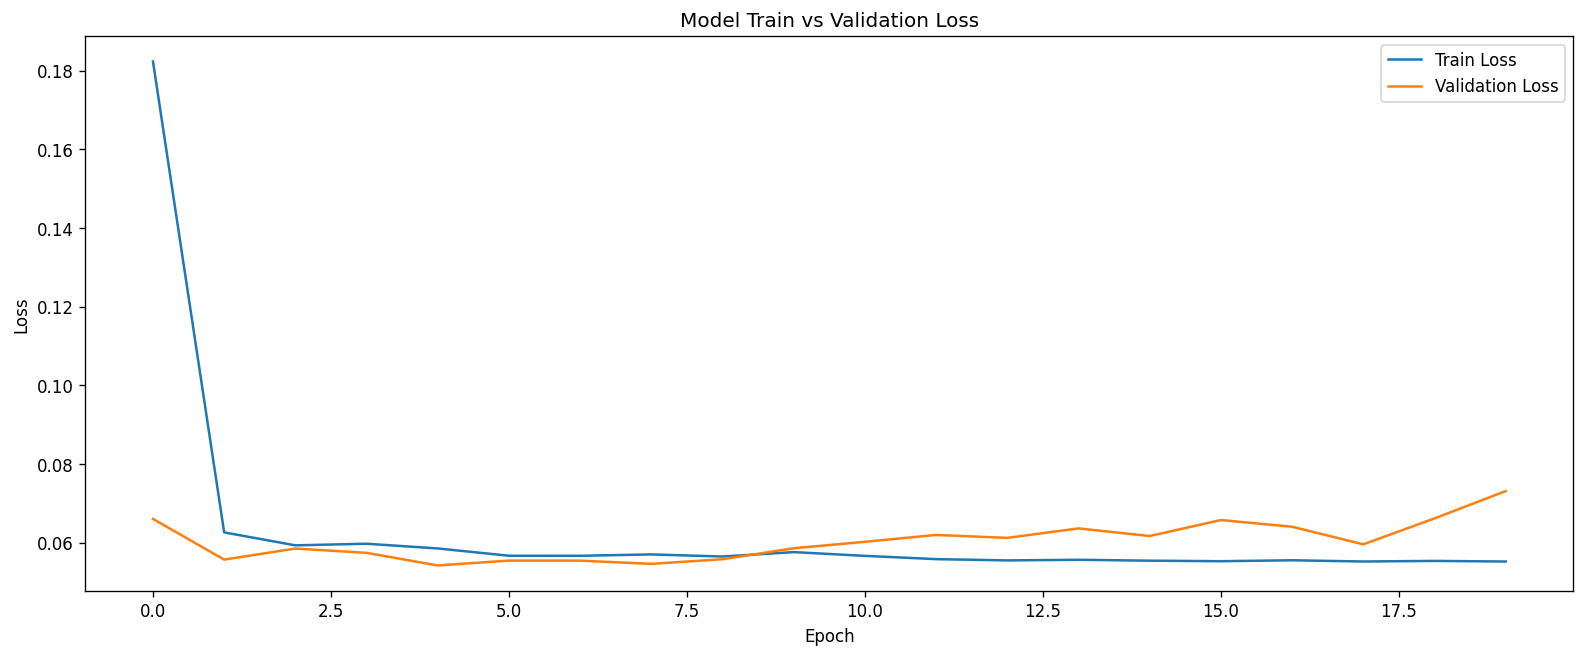

In [117]:
plt.figure(figsize=(16, 6), dpi=120)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(valid_loss_history, label='Validation Loss')
plt.title('Model Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Everything Else**

In [ ]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)